In [2]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.window import Window

# 0) Spark
spark = SparkSession.builder.appName("ERA5-Rebuild-feat").getOrCreate()

# 1) Load hourly (ALL parquet) + time
hourly = spark.read.parquet("data_processed/era5_hourly_*_jochiwon.parquet")
hourly = hourly.withColumn("time", F.to_timestamp("time"))

# 2) Filter 2020-01-01 ~ 2023-12-31
hourly = hourly.filter(
    (F.col("time") >= F.lit("2020-01-01")) &
    (F.col("time") <  F.lit("2024-01-01"))
)

CENTER_LAT = 36.6110
CENTER_LON = 127.2870

# 3) nearest grid point
grid = hourly.select("lat","lon").distinct()
grid2 = grid.withColumn(
    "dist2",
    (F.col("lat") - F.lit(CENTER_LAT))**2 + (F.col("lon") - F.lit(CENTER_LON))**2
)
nearest = grid2.orderBy("dist2").limit(1).collect()[0]
NEAR_LAT = float(nearest["lat"])
NEAR_LON = float(nearest["lon"])
print("Nearest grid:", NEAR_LAT, NEAR_LON)

point = hourly.filter((F.col("lat")==F.lit(NEAR_LAT)) & (F.col("lon")==F.lit(NEAR_LON)))

# 4) units + daily aggregation
point = (point
    .withColumn("t2m_C", F.col("t2m") - F.lit(273.15))
    .withColumn("tp_mm", F.col("tp") * F.lit(1000.0))
    .withColumn("date", F.to_date("time"))
)

daily = (point.groupBy("date")
    .agg(
        F.avg("t2m_C").alias("tmean_C"),
        F.max("t2m_C").alias("tmax_C"),
        F.min("t2m_C").alias("tmin_C"),
        F.stddev("t2m_C").alias("tstd_C"),
        F.sum("tp_mm").alias("prcp_mm_sum"),
        F.max("tp_mm").alias("prcp_mm_max_hour"),
        F.avg("sp").alias("sp_mean"),
        F.avg("d2m").alias("d2m_mean"),
        F.sqrt(F.avg(F.col("u10")*F.col("u10") + F.col("v10")*F.col("v10"))).alias("wind_speed_mean"),
        F.sum("ssrd").alias("ssrd_sum"),
    )
    .withColumn("dtr_C", F.col("tmax_C") - F.col("tmin_C"))
    .withColumn("site_id", F.lit("NEAREST_GRID"))
    .orderBy("date")
)

# 5) lag/rolling + target
w = Window.partitionBy("site_id").orderBy("date")
w7  = w.rowsBetween(-6, 0)
w30 = w.rowsBetween(-29, 0)

feat = (daily
    .withColumn("y_tmean_next", F.lead("tmean_C", 1).over(w))
    .withColumn("tmean_lag1", F.lag("tmean_C", 1).over(w))
    .withColumn("tmean_lag7", F.lag("tmean_C", 7).over(w))
    .withColumn("prcp_lag1",  F.lag("prcp_mm_sum", 1).over(w))
    .withColumn("prcp_lag7",  F.lag("prcp_mm_sum", 7).over(w))
    .withColumn("tmean_roll7",  F.avg("tmean_C").over(w7))
    .withColumn("tmean_roll30", F.avg("tmean_C").over(w30))
    .withColumn("prcp_roll7",   F.avg("prcp_mm_sum").over(w7))
    .withColumn("prcp_roll30",  F.avg("prcp_mm_sum").over(w30))
)

# 6) drop NA rows (초기 rolling + 마지막 target)
feat = feat.dropna(subset=["y_tmean_next","tmean_roll30","prcp_roll30"])

print("feat rows:", feat.count())
feat.show(3, truncate=False)



your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/19 14:38:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/19 14:38:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Nearest grid: 36.5 127.25
feat rows: 1460
+----------+-------------------+------------------+-------------------+-----------------+--------------------+------------------+------------------+------------------+------------------+---------+-----------------+------------+-------------------+-------------------+----------+--------------------+---------+-------------------+-------------------+--------------------+--------------------+
|date      |tmean_C            |tmax_C            |tmin_C             |tstd_C           |prcp_mm_sum         |prcp_mm_max_hour  |sp_mean           |d2m_mean          |wind_speed_mean   |ssrd_sum |dtr_C            |site_id     |y_tmean_next       |tmean_lag1         |tmean_lag7|prcp_lag1           |prcp_lag7|tmean_roll7        |tmean_roll30       |prcp_roll7          |prcp_roll30         |
+----------+-------------------+------------------+-------------------+-----------------+--------------------+------------------+------------------+------------------+-------

In [3]:
import numpy as np
import pandas as pd

pdf = feat.toPandas()
pdf["date"] = pd.to_datetime(pdf["date"])
pdf = pdf.sort_values("date").reset_index(drop=True)

pdf["doy"] = pdf["date"].dt.dayofyear.astype(int)
pdf["sin_doy"] = np.sin(2*np.pi*pdf["doy"]/365.25)
pdf["cos_doy"] = np.cos(2*np.pi*pdf["doy"]/365.25)

print("pdf shape:", pdf.shape)
pdf[["date","tmean_C","y_tmean_next","sin_doy","cos_doy"]].head()


pdf shape: (1460, 25)


,date,tmean_C,y_tmean_next,sin_doy,cos_doy
0,2020-01-01,-0.543962,1.076570,0.017202,0.999852
1,2020-01-02,1.076570,0.173204,0.034398,0.999408
2,2020-01-03,0.173204,0.356368,0.051584,0.998669
3,2020-01-04,0.356368,1.139187,0.068755,0.997634
4,2020-01-05,1.139187,4.610701,0.085906,0.996303


In [4]:
exo_cols = [
    "prcp_mm_sum","prcp_mm_max_hour","sp_mean","d2m_mean","wind_speed_mean","ssrd_sum",
    "tmax_C","tmin_C","tstd_C","dtr_C"
]

clim = (pdf.groupby("doy")[exo_cols].mean().reset_index())
clim.head()


,doy,prcp_mm_sum,prcp_mm_max_hour,sp_mean,d2m_mean,wind_speed_mean,ssrd_sum,tmax_C,tmin_C,tstd_C,dtr_C
0,1,0.252366,0.042558,101343.316406,264.753223,1.991369,8578672.0,2.943445,-6.650183,2.830386,9.593628
1,2,0.013590,0.005603,101378.041667,264.603950,2.580347,9426064.0,2.941614,-6.296332,3.106568,9.237946
2,3,0.014186,0.004768,101315.928385,265.463148,2.117819,10349216.0,3.144907,-6.286719,2.908250,9.431625
3,4,0.135183,0.110388,101310.386719,265.776230,2.098561,9766496.0,4.604608,-5.658759,3.317766,10.263367
4,5,0.211477,0.113606,101310.846354,264.791504,2.122157,8206320.0,3.541162,-5.890021,3.047496,9.431183


In [5]:
feature_cols = [
    # temperature dynamics
    "tmean_C", "tmean_lag1", "tmean_lag7", "tmean_roll7", "tmean_roll30",
    # exogenous (observed during training)
    "prcp_mm_sum","prcp_mm_max_hour","sp_mean","d2m_mean","wind_speed_mean","ssrd_sum",
    "tmax_C","tmin_C","tstd_C","dtr_C",
    # seasonality
    "sin_doy","cos_doy"
]

target_col = "y_tmean_next"

# 결측 제거 (초기 rolling/lag, 마지막 y_tmean_next)
train_df = pdf.dropna(subset=feature_cols + [target_col]).copy()

X_all = train_df[feature_cols].to_numpy(dtype=np.float32)
y_all = train_df[target_col].to_numpy(dtype=np.float32).reshape(-1, 1)

train_df[["date"]].head(), X_all.shape, y_all.shape


(         date
 7  2020-01-08
 8  2020-01-09
 9  2020-01-10
 10 2020-01-11
 11 2020-01-12,
 (1453, 17),
 (1453, 1))

In [6]:
train_mask = (train_df["date"] >= "2020-01-01") & (train_df["date"] < "2023-01-01")
val_mask   = (train_df["date"] >= "2023-01-01") & (train_df["date"] < "2023-07-01")
test_mask  = (train_df["date"] >= "2023-07-01") & (train_df["date"] < "2024-01-01")

X_tr, y_tr = X_all[train_mask], y_all[train_mask]
X_va, y_va = X_all[val_mask],   y_all[val_mask]
X_te, y_te = X_all[test_mask],  y_all[test_mask]

X_tr.shape, X_va.shape, X_te.shape


((1089, 17), (181, 17), (183, 17))

In [7]:
def mae(a,b): return float(np.mean(np.abs(a-b)))
def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))

# persistence: y_hat_next = today tmean_C
yhat_persist = train_df.loc[test_mask, "tmean_C"].to_numpy(dtype=np.float32).reshape(-1,1)
print("Persistence  Test MAE:", mae(yhat_persist, y_te), "RMSE:", rmse(yhat_persist, y_te))


Persistence  Test MAE: 1.8016256093978882 RMSE: 2.5833687782287598


In [8]:
import jax
import jax.numpy as jnp

def fit_ridge(X, y, lam=1e-3):
    X = jnp.asarray(X)
    y = jnp.asarray(y)
    # add bias
    Xb = jnp.concatenate([X, jnp.ones((X.shape[0],1), dtype=X.dtype)], axis=1)
    d = Xb.shape[1]
    I = jnp.eye(d, dtype=X.dtype).at[-1,-1].set(0.0)  # don't regularize bias
    w = jnp.linalg.solve(Xb.T@Xb + lam*I, Xb.T@y)
    return w

def predict_ridge(w, X):
    X = jnp.asarray(X)
    Xb = jnp.concatenate([X, jnp.ones((X.shape[0],1), dtype=X.dtype)], axis=1)
    return Xb @ w

w_ridge = fit_ridge(X_tr, y_tr, lam=1e-2)
yhat_te = np.array(predict_ridge(w_ridge, X_te))

print("Ridge Linear  Test MAE:", mae(yhat_te, y_te), "RMSE:", rmse(yhat_te, y_te))


Ridge Linear  Test MAE: 1.605532169342041 RMSE: 2.234175682067871


In [10]:
pip install optax

/home/roger/miniconda3/envs/fourseason/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [optax]32m3/4 [optax]
Note: you may need to restart the kernel to use updated packages.


In [12]:
import jax
import jax.numpy as jnp
import optax
import numpy as np

key = jax.random.PRNGKey(0)

def init_mlp(key, in_dim, h1=64, h2=32):
    k1, k2, k3 = jax.random.split(key, 3)
    return {
        "W1": jax.random.normal(k1, (in_dim, h1)) * 0.1,
        "b1": jnp.zeros((h1,)),
        "W2": jax.random.normal(k2, (h1, h2)) * 0.1,
        "b2": jnp.zeros((h2,)),
        "W3": jax.random.normal(k3, (h2, 1)) * 0.1,
        "b3": jnp.zeros((1,))
    }

def mlp(params, X):
    h = jnp.maximum(0, X @ params["W1"] + params["b1"])
    h = jnp.maximum(0, h @ params["W2"] + params["b2"])
    return h @ params["W3"] + params["b3"]

@jax.jit
def loss_fn(params, X, y):
    pred = mlp(params, X)
    return jnp.mean((pred - y) ** 2)

# ✅ optimizer는 바깥에서 고정(클로저)시키기
optimizer = optax.adam(1e-3)

@jax.jit
def step(params, opt_state, X, y):
    grads = jax.grad(loss_fn)(params, X, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# ---- standardize (train 기준)
mu = X_tr.mean(axis=0, keepdims=True)
sd = X_tr.std(axis=0, keepdims=True) + 1e-6

Xtr_s = (X_tr - mu) / sd
Xva_s = (X_va - mu) / sd
Xte_s = (X_te - mu) / sd

params = init_mlp(key, Xtr_s.shape[1])
opt_state = optimizer.init(params)

# ---- training
rng = np.random.default_rng(0)
best_params = params
best_val = 1e18
patience, bad = 30, 0

Xva_j = jnp.asarray(Xva_s, dtype=jnp.float32)
yva_j = jnp.asarray(y_va, dtype=jnp.float32)

for epoch in range(400):
    idx = rng.permutation(Xtr_s.shape[0])
    for start in range(0, len(idx), 64):
        b = idx[start:start+64]
        xb = jnp.asarray(Xtr_s[b], dtype=jnp.float32)
        yb = jnp.asarray(y_tr[b], dtype=jnp.float32)
        params, opt_state = step(params, opt_state, xb, yb)

    val_mse = float(loss_fn(params, Xva_j, yva_j))
    if val_mse < best_val - 1e-7:
        best_val = val_mse
        best_params = params
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            break

# ---- evaluation
yhat_mlp = np.array(mlp(best_params, jnp.asarray(Xte_s, dtype=jnp.float32)))
print("Best val MSE:", best_val)
print("MLP Test MAE:", mae(yhat_mlp, y_te), "RMSE:", rmse(yhat_mlp, y_te))



Best val MSE: 6.227038383483887
MLP Test MAE: 1.6293836832046509 RMSE: 2.2787961959838867


In [13]:
import numpy as np
import pandas as pd

# --- train 기간 정의 (너희 분할과 동일)
train_mask_pdf = (train_df["date"] >= "2020-01-01") & (train_df["date"] < "2023-01-01")
train_part = train_df.loc[train_mask_pdf].copy()

X_train = train_part[feature_cols].to_numpy(dtype=np.float32)
y_train = train_part["y_tmean_next"].to_numpy(dtype=np.float32).reshape(-1,1)

yhat_train = np.array(predict_ridge(w_ridge, X_train), dtype=np.float32)
resid = (y_train - yhat_train).reshape(-1)

print("Residuals: mean", float(resid.mean()), "std", float(resid.std()))
print(pd.Series(resid).describe())


Residuals: mean -0.00024169732932932675 std 2.1794705390930176
count    1089.000000
mean       -0.000242
std         2.180472
min        -8.810131
25%        -1.240170
50%         0.127682
75%         1.346371
max         7.178654
dtype: float64


In [14]:
# clim 없으면 생성
exo_cols = [
    "prcp_mm_sum","prcp_mm_max_hour","sp_mean","d2m_mean","wind_speed_mean","ssrd_sum",
    "tmax_C","tmin_C","tstd_C","dtr_C"
]
if "clim" not in globals():
    clim = (pdf.groupby(pdf["date"].dt.dayofyear)[exo_cols].mean().reset_index())
    clim.columns = ["doy"] + exo_cols

clim.head()


,doy,prcp_mm_sum,prcp_mm_max_hour,sp_mean,d2m_mean,wind_speed_mean,ssrd_sum,tmax_C,tmin_C,tstd_C,dtr_C
0,1,0.252366,0.042558,101343.316406,264.753223,1.991369,8578672.0,2.943445,-6.650183,2.830386,9.593628
1,2,0.013590,0.005603,101378.041667,264.603950,2.580347,9426064.0,2.941614,-6.296332,3.106568,9.237946
2,3,0.014186,0.004768,101315.928385,265.463148,2.117819,10349216.0,3.144907,-6.286719,2.908250,9.431625
3,4,0.135183,0.110388,101310.386719,265.776230,2.098561,9766496.0,4.604608,-5.658759,3.317766,10.263367
4,5,0.211477,0.113606,101310.846354,264.791504,2.122157,8206320.0,3.541162,-5.890021,3.047496,9.431183


In [15]:
import math

def get_clim_row(doy: int):
    row = clim[clim["doy"] == doy]
    if len(row) == 0:  # safety
        row = clim.iloc[[0]]
    return row.iloc[0]

def build_feature(curr_date, t_hist):
    """
    curr_date: pandas Timestamp (예측할 날짜 = 오늘)
    t_hist: list of tmean_C values up to yesterday 포함 (길이>=30 권장)
    """
    doy = int(pd.Timestamp(curr_date).dayofyear)
    sin_doy = np.sin(2*np.pi*doy/365.25)
    cos_doy = np.cos(2*np.pi*doy/365.25)

    # 오늘 tmean_C는 히스토리 마지막 값이라고 두자
    tmean_C = t_hist[-1]
    tmean_lag1 = t_hist[-2]
    tmean_lag7 = t_hist[-8] if len(t_hist) >= 8 else t_hist[0]
    tmean_roll7 = float(np.mean(t_hist[-7:]))
    tmean_roll30 = float(np.mean(t_hist[-30:]))

    exo = get_clim_row(doy)

    # feature_cols 순서와 정확히 동일하게 만들기!
    feat_vec = np.array([
        # temperature dynamics
        tmean_C, tmean_lag1, tmean_lag7, tmean_roll7, tmean_roll30,
        # exogenous (climatology)
        float(exo["prcp_mm_sum"]), float(exo["prcp_mm_max_hour"]), float(exo["sp_mean"]),
        float(exo["d2m_mean"]), float(exo["wind_speed_mean"]), float(exo["ssrd_sum"]),
        float(exo["tmax_C"]), float(exo["tmin_C"]), float(exo["tstd_C"]), float(exo["dtr_C"]),
        # seasonality
        float(sin_doy), float(cos_doy)
    ], dtype=np.float32)

    return feat_vec


In [25]:
def simulate_2024_ensemble(n_runs=50, random_seed=0):
    rng = np.random.default_rng(random_seed)

    # ✅ 날짜 조건 제거 → 마지막 31개 관측치 사용
    seed_df = (
        pdf[["date","tmean_C"]]
        .dropna()
        .sort_values("date")
        .tail(31)
    )

    if len(seed_df) < 31:
        raise ValueError("Need >=31 total observations for rolling(30).")

    seed_hist = seed_df["tmean_C"].to_list()

    start = pd.Timestamp("2024-01-01")
    end   = pd.Timestamp("2024-12-31")
    dates = pd.date_range(start, end, freq="D")

    sims = np.zeros((len(dates), n_runs), dtype=np.float32)

    for r in range(n_runs):
        t_hist = seed_hist.copy()
        for i, d in enumerate(dates):
            x = build_feature(d, t_hist)[None, :]
            mu = float(np.array(predict_ridge(w_ridge, x))[0,0])  # 기대값
            eps = float(rng.choice(resid))                        # 잔차 샘플
            y = mu + eps
            sims[i, r] = y
            t_hist.append(y)

    sim_df = pd.DataFrame({"date": dates})
    for r in range(n_runs):
        sim_df[f"run_{r:02d}"] = sims[:, r]

    return sim_df



In [18]:
sim2024 = simulate_2024_ensemble(n_runs=50, random_seed=42)
sim2024.head()

,date,run_00,run_01,run_02,run_03,run_04,run_05,run_06,run_07,run_08,...,run_40,run_41,run_42,run_43,run_44,run_45,run_46,run_47,run_48,run_49
0,2024-01-01,0.835718,-5.440931,1.497578,-2.903733,0.104578,-0.919501,-3.784145,-2.417230,-0.192120,...,0.311956,2.837073,1.747341,3.743806,3.058041,-1.277714,-4.397221,1.887553,-1.716261,0.289023
1,2024-01-02,-3.220971,-2.900376,-0.607214,-0.875536,-4.294212,2.039608,-0.594675,0.959789,3.268045,...,1.091959,3.795397,-4.033995,-1.361149,1.420076,0.017307,-2.609422,-5.469372,1.110633,-0.717500
2,2024-01-03,-0.680345,-0.710495,-3.550228,-0.155500,-2.443953,-0.878756,0.013554,-2.995960,0.829981,...,4.984420,2.690530,-2.358788,-1.495424,-2.278909,-5.499107,-0.439599,-0.305246,0.281012,3.789268
3,2024-01-04,-2.141741,0.332409,1.588591,-5.325377,-1.328345,-5.523062,0.804590,1.422747,0.985469,...,1.758946,-0.586460,-5.221256,1.909522,0.374485,0.211969,-2.837708,-0.922085,-1.860779,-0.119623
4,2024-01-05,0.362268,-1.750756,-1.898814,-0.493555,0.663309,-0.444927,1.254783,2.436552,-4.449528,...,0.645693,-1.139606,-3.888017,-1.581379,1.449488,-0.318205,-2.885162,2.316700,-1.409380,0.869272


In [19]:
runs = [c for c in sim2024.columns if c.startswith("run_")]
vals = sim2024[runs].to_numpy(dtype=np.float32)

sim2024_sum = pd.DataFrame({
    "date": sim2024["date"],
    "mean": vals.mean(axis=1),
    "p10": np.percentile(vals, 10, axis=1),
    "p90": np.percentile(vals, 90, axis=1),
})

sim2024_sum.head()


,date,mean,p10,p90
0,2024-01-01,0.104624,-2.427454,2.818681
1,2024-01-02,-0.509970,-3.309801,2.050329
2,2024-01-03,0.198475,-2.507085,2.917264
3,2024-01-04,-0.017858,-2.860921,1.953819
4,2024-01-05,-0.136296,-2.155410,2.453403


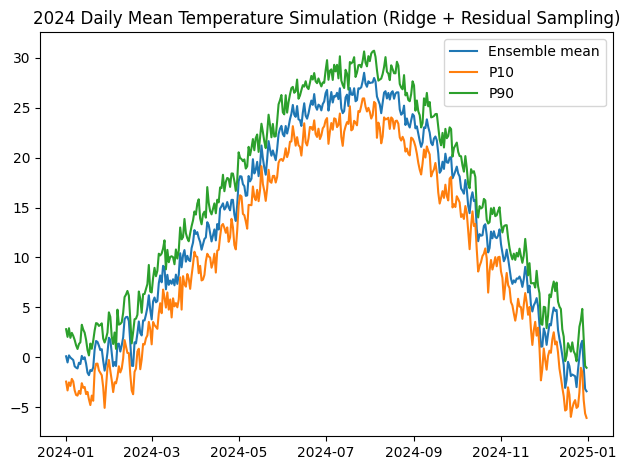

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(sim2024_sum["date"], sim2024_sum["mean"], label="Ensemble mean")
plt.plot(sim2024_sum["date"], sim2024_sum["p10"], label="P10")
plt.plot(sim2024_sum["date"], sim2024_sum["p90"], label="P90")
plt.title("2024 Daily Mean Temperature Simulation (Ridge + Residual Sampling)")
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
# 관측 구간(2023년)에서 일별 차분 표준편차
obs_2023 = pdf[(pdf["date"] >= "2023-01-01") & (pdf["date"] <= "2023-12-31")].sort_values("date")
obs_diff_std = float(np.std(np.diff(obs_2023["tmean_C"].to_numpy(dtype=np.float32))))

# 시뮬 2024에서 ensemble mean 기준 차분 표준편차
sim_diff_std = float(np.std(np.diff(sim2024_sum["mean"].to_numpy(dtype=np.float32))))

print("Obs 2023 day-to-day diff std:", obs_diff_std)
print("Sim 2024 (ens mean) day-to-day diff std:", sim_diff_std)

# ensemble 하나(run_00)의 diff std도 보기
sim0_diff_std = float(np.std(np.diff(sim2024["run_00"].to_numpy(dtype=np.float32))))
print("Sim 2024 (run_00) day-to-day diff std:", sim0_diff_std)


Obs 2023 day-to-day diff std: 2.793475389480591
Sim 2024 (ens mean) day-to-day diff std: 0.9752737879753113
Sim 2024 (run_00) day-to-day diff std: 2.9503774642944336


In [ ]:
def simulate_future_ensemble(start_date, end_date, n_runs=50, random_seed=0):
    rng = np.random.default_rng(random_seed)

    seed_df = (
        pdf[["date","tmean_C"]]
        .dropna()
        .sort_values("date")
        .tail(31)
    )

    seed_hist = seed_df["tmean_C"].to_list()

    dates = pd.date_range(start_date, end_date, freq="D")
    sims = np.zeros((len(dates), n_runs), dtype=np.float32)

    for r in range(n_runs):
        t_hist = seed_hist.copy()
        for i, d in enumerate(dates):
            x = build_feature(d, t_hist)[None, :]
            mu = float(np.array(predict_ridge(w_ridge, x))[0,0])
            eps = float(rng.choice(resid))
            y = mu + eps
            sims[i, r] = y
            t_hist.append(y)

    sim_df = pd.DataFrame({"date": dates})
    for r in range(n_runs):
        sim_df[f"run_{r:02d}"] = sims[:, r]

    return sim_df


# ▶ 실행
sim2025_2026 = simulate_future_ensemble(
    start_date="2025-01-01",
    end_date="2026-12-31",
    n_runs=50,
    random_seed=42
)

sim2025_2026.head()
